In [3]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [6]:
index_train = np.where(person_train_valid==0)[0]
index_test = np.where(person_test==0)[0]

X_train_valid = X_train_valid[index_train,:,:]
y_train_valid = y_train_valid[index_train]
X_test = X_test[index_test,:,:]
y_test = y_test[index_test]

In [7]:
print('For one participant')
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

For one participant
Training/Valid data shape: (237, 22, 1000)
Test data shape: (50, 22, 1000)
Training/Valid target shape: (237,)
Test target shape: (50,)


In [8]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

In [9]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting

num_samples = 237
num_samples_valid = 50

ind_valid = np.random.choice(num_samples, num_samples_valid, replace=False)
ind_train = np.array(list(set(range(num_samples)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (187, 22, 1000)
Shape of validation set: (50, 22, 1000)
Shape of training labels: (187,)
Shape of validation labels: (50,)
Shape of training labels after categorical conversion: (187, 4)
Shape of validation labels after categorical conversion: (50, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of training set after adding width info: (187, 22, 1000, 1)
Shape of validation set after adding width info: (50, 22, 1000, 1)
Shape of test set after adding width info: (50, 22, 1000, 1)
Shape of training set after dimension reshaping: (187, 1000, 1, 22)
Shape of validation set after dimension reshaping: (50, 1000, 1, 22)
Shape of test set after dimension reshaping: (50, 1000, 1, 22)


# FC Model for subject 0

In [25]:
# Building the FC model using sequential class
basic_fc_model = Sequential()

# First FC layer 
basic_fc_model.add(Dense(10,input_shape=(1000,1,22))) # For the first layer we have to specify the input shape

# BN layer
basic_fc_model.add(BatchNormalization())

# Second FC layer
basic_fc_model.add(Dense(20)) # We don't need to specify the input shape it's inferred from the previous layer

# BN layer
basic_fc_model.add(BatchNormalization())

# Third FC layer
basic_fc_model.add(Dense(50))

# BN layer
basic_fc_model.add(BatchNormalization())

# Output layer with Softmax activation
basic_fc_model.add(Flatten()) # Flattens the input
basic_fc_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
basic_fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000, 1, 10)       230       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 1, 10)       40        
_________________________________________________________________
dense_1 (Dense)              (None, 1000, 1, 20)       220       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 1, 20)       80        
_________________________________________________________________
dense_2 (Dense)              (None, 1000, 1, 50)       1050      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 1, 50)       200       
_________________________________________________________________
flatten (Flatten)            (None, 50000)             0

In [26]:
# Model parameters
import tensorflow as tf
learning_rate = 1e-3
epochs = 50
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

In [27]:
# Compiling the model
basic_fc_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_fc_model_results = basic_fc_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 187 samples, validate on 50 samples
Epoch 1/50
187/187 [==============================] - 1s 8ms/sample - loss: 3.0482 - accuracy: 0.2406 - val_loss: 8.8977 - val_accuracy: 0.4200
Epoch 2/50
187/187 [==============================] - 0s 2ms/sample - loss: 0.6310 - accuracy: 0.8610 - val_loss: 8.8806 - val_accuracy: 0.4400
Epoch 3/50
187/187 [==============================] - 0s 2ms/sample - loss: 0.1417 - accuracy: 0.9786 - val_loss: 8.8029 - val_accuracy: 0.3800
Epoch 4/50
187/187 [==============================] - 0s 2ms/sample - loss: 0.0507 - accuracy: 0.9947 - val_loss: 8.7312 - val_accuracy: 0.3800
Epoch 5/50
187/187 [==============================] - 0s 2ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 8.8599 - val_accuracy: 0.3800
Epoch 6/50
187/187 [==============================] - 0s 2ms/sample - loss: 0.0053 - accuracy: 1.0000 - val_loss: 8.8808 - val_accuracy: 0.3800
Epoch 7/50
187/187 [==============================] - 0s 2ms/sample - loss: 0.0027 - accura

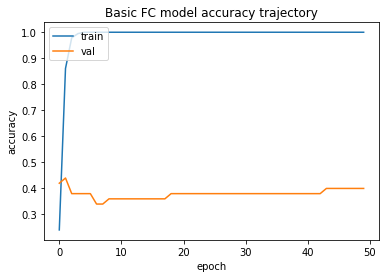

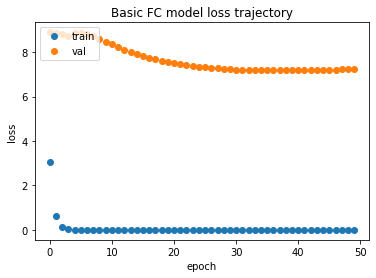

In [28]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_fc_model_results.history['accuracy'])
plt.plot(basic_fc_model_results.history['val_accuracy'])
plt.title('Basic FC model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_fc_model_results.history['loss'],'o')
plt.plot(basic_fc_model_results.history['val_loss'],'o')
plt.title('Basic FC model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
## Testing the basic FC model

score = basic_fc_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic FC model:',score[1])

Test accuracy of the basic FC model: 0.26


# CNN Model for subject 0

In [30]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 1, 25)       5525      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 334, 1, 25)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 334, 1, 25)        100       
_________________________________________________________________
dropout (Dropout)            (None, 334, 1, 25)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 334, 1, 50)        12550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 1, 50)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 1, 50)       

In [31]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

In [32]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Train on 187 samples, validate on 50 samples
Epoch 1/50
187/187 [==============================] - 1s 8ms/sample - loss: 2.4597 - accuracy: 0.2193 - val_loss: 4.8414 - val_accuracy: 0.3000
Epoch 2/50
187/187 [==============================] - 0s 2ms/sample - loss: 1.8863 - accuracy: 0.3316 - val_loss: 7.2195 - val_accuracy: 0.3400
Epoch 3/50
187/187 [==============================] - 0s 3ms/sample - loss: 2.0150 - accuracy: 0.3422 - val_loss: 7.2835 - val_accuracy: 0.3400
Epoch 4/50
187/187 [==============================] - 0s 2ms/sample - loss: 1.9120 - accuracy: 0.3316 - val_loss: 6.1955 - val_accuracy: 0.3800
Epoch 5/50
187/187 [==============================] - 0s 2ms/sample - loss: 1.7726 - accuracy: 0.4171 - val_loss: 5.8035 - val_accuracy: 0.3600
Epoch 6/50
187/187 [==============================] - 0s 2ms/sample - loss: 1.5919 - accuracy: 0.4171 - val_loss: 5.7134 - val_accuracy: 0.3800
Epoch 7/50
187/187 [==============================] - 0s 2ms/sample - loss: 1.5106 - accura

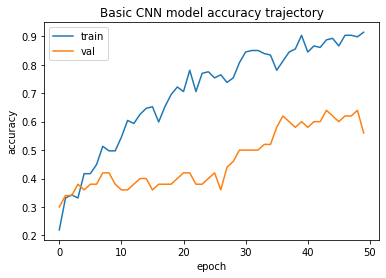

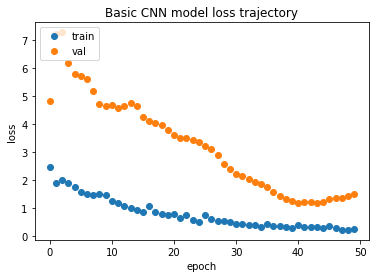

In [33]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.54


# LSTM Model for Subject 0

In [49]:
rnn_model=Sequential()

rnn_model.add(LSTM(128,input_shape=(1000,22),activation='relu',return_sequences=True))

#rnn_model.add(Dropout(0.2))

rnn_model.add(LSTM(64,activation='relu', return_sequences=True))

#rnn_model.add(Dropout(0.2))

rnn_model.add(LSTM(32,activation='relu'))

#rnn_model.add(Dropout(0.2))


# for units in [128,128,64,32]:

# model.add(Dense(units,activation='relu'))
# model.add(Dropout(0.2))

rnn_model.add(Dense(16,activation='relu'))

#rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(4,activation='softmax'))

rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(rnn_model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 1000, 128)         77312     
_________________________________________________________________
lstm_42 (LSTM)               (None, 1000, 64)          49408     
_________________________________________________________________
lstm_43 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 68        
Total params: 139,732
Trainable params: 139,732
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
# Shape of training set after adding width info: (187, 22, 1000, 1)
# Shape of validation set after adding width info: (50, 22, 1000, 1)
# Shape of test set after adding width info: (50, 22, 1000, 1)
# Shape of training set after dimension reshaping: (187, 1000, 1, 22)
# Shape of validation set after dimension reshaping: (50, 1000, 1, 22)
# Shape of test set after dimension reshaping: (50, 1000, 1, 22)

x_train_rnn = x_train.reshape((187,1000,22))
y_train_rnn = y_train

x_valid_rnn = x_valid.reshape((50,1000,22))
y_valid_rnn = y_valid

In [ ]:
basic_rnn_model_results = rnn_model.fit(x_train_rnn, y_train_rnn,
           batch_size=32,
           epochs=50,
           validation_data=(x_valid_rnn, y_valid_rnn), verbose=True)

# print(history.history['loss'])
# print(history.history['accuracy'])

Train on 187 samples, validate on 50 samples
Epoch 1/50
187/187 [==============================] - 16s 84ms/sample - loss: nan - accuracy: 0.2406 - val_loss: nan - val_accuracy: 0.1800
Epoch 2/50
187/187 [==============================] - 13s 69ms/sample - loss: nan - accuracy: 0.2727 - val_loss: nan - val_accuracy: 0.1800
Epoch 3/50
187/187 [==============================] - 14s 73ms/sample - loss: nan - accuracy: 0.2727 - val_loss: nan - val_accuracy: 0.1800
Epoch 4/50
187/187 [==============================] - 15s 79ms/sample - loss: nan - accuracy: 0.2727 - val_loss: nan - val_accuracy: 0.1800
Epoch 5/50
187/187 [==============================] - 14s 72ms/sample - loss: nan - accuracy: 0.2727 - val_loss: nan - val_accuracy: 0.1800
Epoch 6/50
187/187 [==============================] - 13s 72ms/sample - loss: nan - accuracy: 0.2727 - val_loss: nan - val_accuracy: 0.1800
Epoch 7/50
187/187 [==============================] - 13s 71ms/sample - loss: nan - accuracy: 0.2727 - val_loss: na

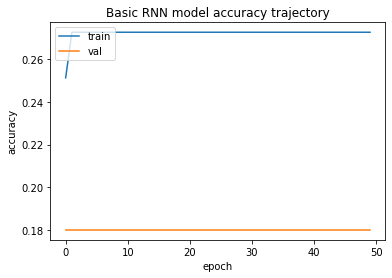

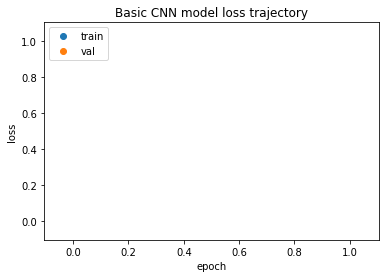

In [30]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_rnn_model_results.history['accuracy'])
plt.plot(basic_rnn_model_results.history['val_accuracy'])
plt.title('Basic RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_rnn_model_results.history['loss'],'o')
plt.plot(basic_rnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
x_test_rnn = x_test.reshape(50,1000,22)
y_test_rnn = y_test

In [33]:
## Testing the basic RNN model

rnn_score = rnn_model.evaluate(x_test_rnn, y_test_rnn, verbose=0)
print('Test accuracy of the basic CNN model:',rnn_score[1])

Test accuracy of the basic CNN model: 0.24
